# Mini-Project: Diagnosing and Improving a Machine Learning Model
## Predicting Student Academic Performance

**Research Question:** To what extent do selected student-related features predict student performance in this dataset?

---
## Section 0: Setup & Imports

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import umap
UMAP_AVAILABLE = True


sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
print('All imports successful.')

All imports successful.


---
## Section 1: Load & Inspect Data

In [140]:

DATA_PATH = 'Sapfile1.arff'

try:
    from scipy.io import arff as scipy_arff
    data, meta = scipy_arff.loadarff(DATA_PATH)
    df = pd.DataFrame(data)
except Exception:
    try:
        import arff as liac_arff
        with open(DATA_PATH, 'r') as f:
            arff_data = liac_arff.load(f)
        cols = [a[0] for a in arff_data['attributes']]
        df = pd.DataFrame(arff_data['data'], columns=cols)
    except Exception as e:
        raise RuntimeError(f'Failed to load ARFF file {DATA_PATH}: {e}')

for col in df.select_dtypes([object]).columns:
    if df[col].apply(lambda x: isinstance(x, (bytes, bytearray))).any():
        df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, (bytes, bytearray)) else x)

print(f'Shape: {df.shape}')
df.head()

Shape: (131, 22)


,ge,cst,tnp,twp,iap,esp,arr,ms,ls,as,...,fq,mq,fo,mo,nf,sh,ss,me,tt,atd
0,F,G,Good,Good,Vg,Good,Y,Unmarried,V,Paid,...,Um,10,Farmer,Housewife,Large,Poor,Govt,Asm,Small,Good
1,M,OBC,Vg,Vg,Vg,Vg,N,Unmarried,V,Paid,...,Um,Il,Service,Service,Small,Poor,Govt,Asm,Average,Average
2,F,OBC,Good,Good,Vg,Good,N,Unmarried,V,Paid,...,12,10,Service,Housewife,Average,Average,Govt,Asm,Large,Good
3,M,MOBC,Pass,Good,Vg,Good,N,Unmarried,V,Paid,...,12,Um,Business,Business,Large,Poor,Govt,Asm,Average,Average
4,M,G,Good,Good,Vg,Vg,N,Unmarried,V,Paid,...,10,12,Service,Housewife,Large,Poor,Private,Asm,Small,Good


In [141]:
print(df.dtypes)
print('\nMissing values:')
print(df.isnull().sum())

ge     str
cst    str
tnp    str
twp    str
iap    str
esp    str
arr    str
ms     str
ls     str
as     str
fmi    str
fs     str
fq     str
mq     str
fo     str
mo     str
nf     str
sh     str
ss     str
me     str
tt     str
atd    str
dtype: object

Missing values:
ge     0
cst    0
tnp    0
twp    0
iap    0
esp    0
arr    0
ms     0
ls     0
as     0
fmi    0
fs     0
fq     0
mq     0
fo     0
mo     0
nf     0
sh     0
ss     0
me     0
tt     0
atd    0
dtype: int64


Target variable (tnp) distribution:
tnp
Good    59
Vg      38
Pass    25
Best     9
Name: count, dtype: int64


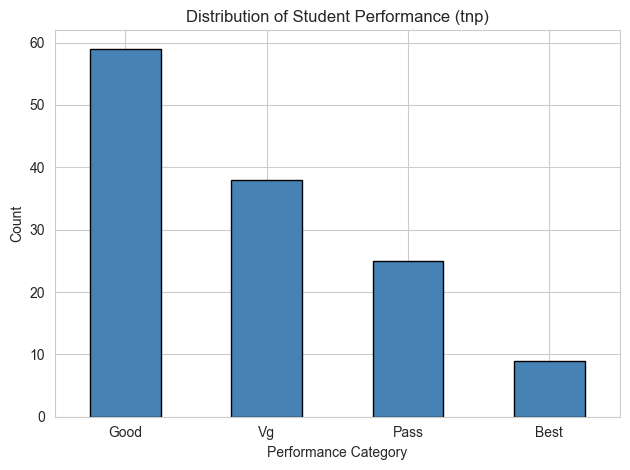

In [142]:
print('Target variable (tnp) distribution:')
print(df['tnp'].value_counts())

df['tnp'].value_counts().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Distribution of Student Performance (tnp)')
plt.xlabel('Performance Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

---
## Section 2: Feature Selection & Justification

We select four features based on domain reasoning:

| Feature | Description | Rationale |
|---------|-------------|----------|
| `atd`   | Attendance percentage | Direct engagement with coursework; consistently linked to academic outcomes in the literature |
| `iap`   | Internal assessment performance | Measures ongoing academic effort; likely a strong direct predictor of final performance |
| `fmi`   | Family monthly income | Socioeconomic status affects access to resources, tutoring, and study time |
| `fq`    | Father's qualification | Parental education level correlates with academic support and motivation at home |

These features represent a mix of **academic behavior** (atd, iap) and **socioeconomic background** (fmi, fq), offering a balanced view of factors likely to influence performance.

In [143]:
FEATURES = ['atd', 'iap', 'fmi', 'fq']
TARGET   = 'tnp'

df_enc = df.copy()

for col in FEATURES + [TARGET]:
    try:
        pd.to_numeric(df_enc[col])
    except (ValueError, TypeError):
        le = LabelEncoder()
        df_enc[col] = le.fit_transform(df_enc[col].astype(str))

X = df_enc[FEATURES].copy()
y = df_enc[TARGET].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=FEATURES)

print('Feature matrix shape:', X_scaled.shape)
print('Target classes:', sorted(y.unique()))
X_scaled_df.describe()

Feature matrix shape: (131, 4)
Target classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


,atd,iap,fmi,fq
count,1.310000e+02,1.310000e+02,1.310000e+02,1.310000e+02
mean,1.355998e-17,7.796986e-17,1.220398e-16,-1.084798e-16
std,1.003839e+00,1.003839e+00,1.003839e+00,1.003839e+00
min,-1.151279e+00,-1.840251e+00,-1.616865e+00,-1.403192e+00
25%,-1.151279e+00,-8.985600e-01,-8.265319e-01,-8.719258e-01
50%,1.953063e-01,4.313088e-02,7.541349e-01,1.906070e-01
75%,1.953063e-01,9.848218e-01,7.541349e-01,1.253140e+00
max,1.541892e+00,9.848218e-01,1.544468e+00,1.253140e+00


---
## Section 3: Evaluation Metric

**Chosen metric: Macro-averaged F1-score**

**Justification:** The target variable `tnp` has five ordinal categories (`Best`, `Vg`, `Good`, `Pass`, `Fail`). The class distribution is uneven, with underrepresented categories such as `Fail`. Accuracy would be misleading here because a model could achieve high accuracy by simply predicting the dominant classes. Macro F1 computes F1 independently for each class and then averages, giving equal weight to minority classes. This ensures the model is evaluated on its ability to distinguish *all* performance groups, not just the most common ones.

---
## Section 4: Baseline Model — Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

baseline = LogisticRegression(max_iter=1000, random_state=42)
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

base_f1  = f1_score(y_test, y_pred_base, average='macro')
base_acc = accuracy_score(y_test, y_pred_base)

print(f'Baseline Logistic Regression')
print(f'  Macro F1 : {base_f1:.4f}')
print(f'  Accuracy : {base_acc:.4f}')
print()
print(classification_report(y_test, y_pred_base))

Baseline Logistic Regression
  Macro F1 : 0.1463
  Accuracy : 0.3636

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.46      0.80      0.59        15
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        10

    accuracy                           0.36        33
   macro avg       0.12      0.20      0.15        33
weighted avg       0.21      0.36      0.27        33



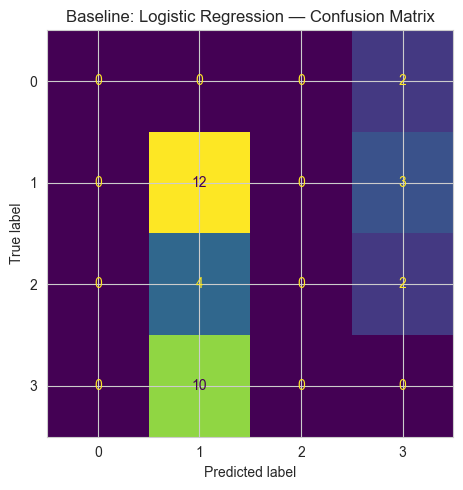

In [145]:
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_base, ax=ax, colorbar=False)
ax.set_title('Baseline: Logistic Regression — Confusion Matrix')
plt.tight_layout()
plt.show()

---
## Section 5: K-Means Clustering — Data Structure Analysis

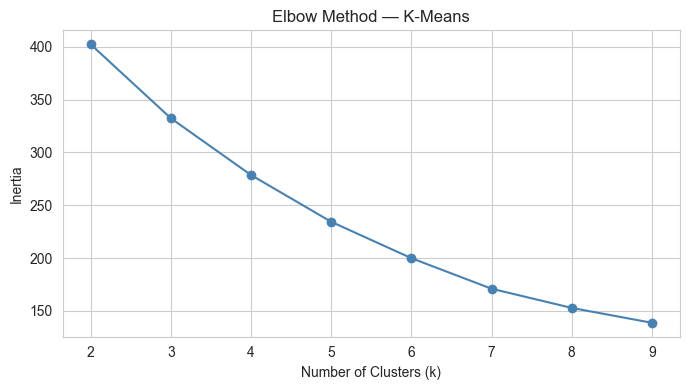

In [146]:
inertias = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K_range, inertias, 'o-', color='steelblue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method — K-Means')
plt.tight_layout()
plt.show()

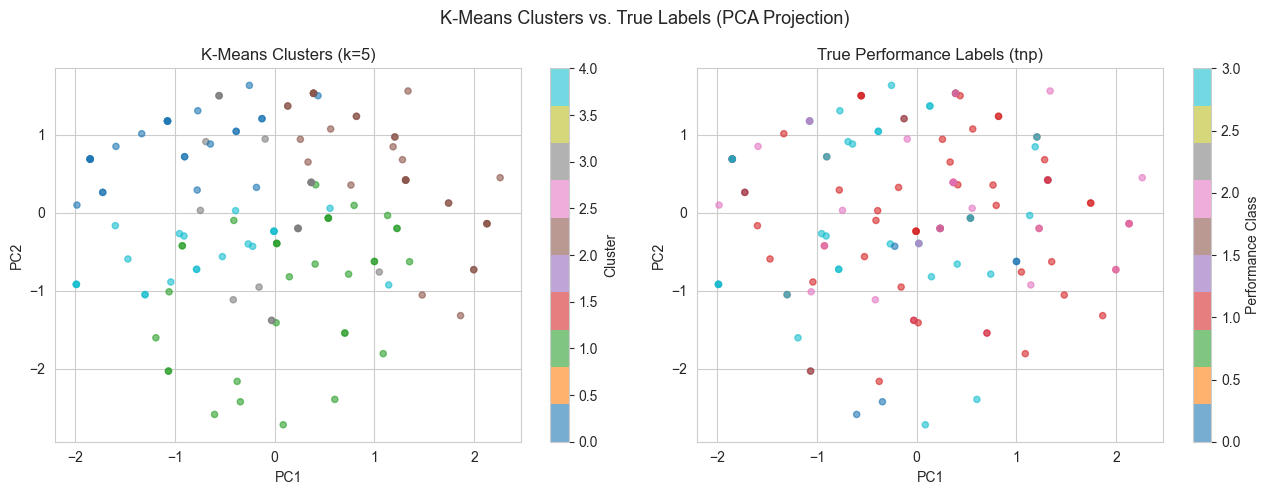

In [147]:
K_FINAL = 5
kmeans = KMeans(n_clusters=K_FINAL, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

df_enc['kmeans_cluster'] = cluster_labels

from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1],
                          c=cluster_labels, cmap='tab10', alpha=0.6, s=20)
axes[0].set_title('K-Means Clusters (k=5)')
axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2')
plt.colorbar(scatter, ax=axes[0], label='Cluster')

scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1],
                           c=y, cmap='tab10', alpha=0.6, s=20)
axes[1].set_title('True Performance Labels (tnp)')
axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC2')
plt.colorbar(scatter2, ax=axes[1], label='Performance Class')

plt.suptitle('K-Means Clusters vs. True Labels (PCA Projection)', fontsize=13)
plt.tight_layout()
plt.show()

Label distribution within each K-Means cluster (row-normalized):
tnp                 0      1      2      3
kmeans_cluster                            
0               0.077  0.346  0.154  0.423
1               0.121  0.364  0.152  0.364
2               0.000  0.594  0.219  0.188
3               0.053  0.526  0.368  0.053
4               0.095  0.429  0.095  0.381


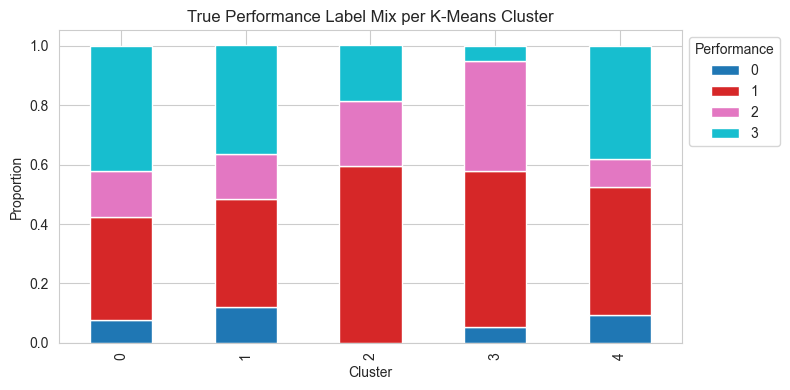

In [148]:
cross_tab = pd.crosstab(df_enc['kmeans_cluster'], df_enc[TARGET], normalize='index').round(3)
print('Label distribution within each K-Means cluster (row-normalized):')
print(cross_tab)

cross_tab.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='tab10', edgecolor='white')
plt.title('True Performance Label Mix per K-Means Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Performance', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tight_layout()
plt.show()

### K-Means Interpretation

The stacked bar chart above shows the distribution of true performance labels within each cluster. If clusters were perfectly separable, each cluster would be dominated by a single label. **Significant mixing of labels within clusters suggests the feature space does not cleanly separate performance groups**, which directly implies a performance ceiling for any supervised classifier trained on these features.

---
## Section 6: Gaussian Mixture Model — Uncertainty Analysis

In [149]:
N_COMPONENTS = 5
gmm = GaussianMixture(n_components=N_COMPONENTS, covariance_type='full', random_state=42)
gmm.fit(X_scaled)

probs = gmm.predict_proba(X_scaled)     
gmm_hard = gmm.predict(X_scaled)            

max_prob = probs.max(axis=1)
print(f'Mean max cluster probability : {max_prob.mean():.3f}')
print(f'Students with max_prob < 0.60 : {(max_prob < 0.60).sum()} ({(max_prob < 0.60).mean()*100:.1f}%)')

Mean max cluster probability : 0.994
Students with max_prob < 0.60 : 1 (0.8%)


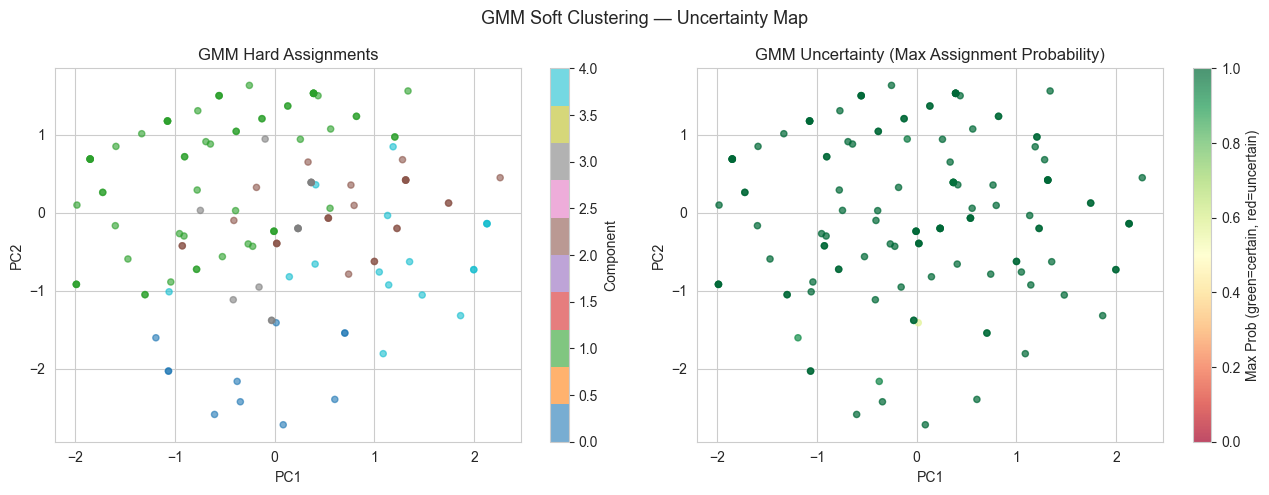

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

sc1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1],
                      c=gmm_hard, cmap='tab10', alpha=0.6, s=20)
axes[0].set_title('GMM Hard Assignments')
axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2')
plt.colorbar(sc1, ax=axes[0], label='Component')

sc2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1],
                      c=max_prob, cmap='RdYlGn', alpha=0.7, s=20, vmin=0, vmax=1)
axes[1].set_title('GMM Uncertainty (Max Assignment Probability)')
axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC2')
plt.colorbar(sc2, ax=axes[1], label='Max Prob (green=certain, red=uncertain)')

plt.suptitle('GMM Soft Clustering — Uncertainty Map', fontsize=13)
plt.tight_layout()
plt.show()

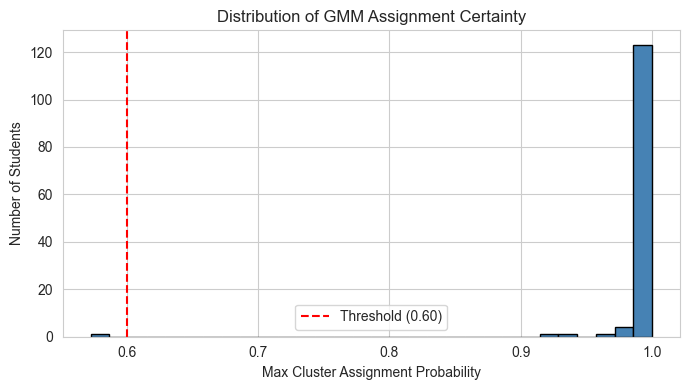

In [151]:
plt.figure(figsize=(7, 4))
plt.hist(max_prob, bins=30, color='steelblue', edgecolor='black')
plt.axvline(0.60, color='red', linestyle='--', label='Threshold (0.60)')
plt.xlabel('Max Cluster Assignment Probability')
plt.ylabel('Number of Students')
plt.title('Distribution of GMM Assignment Certainty')
plt.legend()
plt.tight_layout()
plt.show()

### GMM Interpretation

Students falling in red zones on the uncertainty map sit in overlapping regions between Gaussian components. These students have ambiguous feature profiles — their attendance, assessment scores, income level, and parental education do not clearly place them in a single group. This overlap represents **irreducible ambiguity** in the dataset: even a perfect classifier cannot correctly label students whose feature vectors are shared across performance classes. This provides a principled explanation for why we may see a performance ceiling in the supervised models.

---
## Section 7: Ensemble Model — Random Forest Classifier

In [152]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_f1  = f1_score(y_test, y_pred_rf, average='macro')
rf_acc = accuracy_score(y_test, y_pred_rf)

print(f'Random Forest Classifier')
print(f'  Macro F1 : {rf_f1:.4f}')
print(f'  Accuracy : {rf_acc:.4f}')
print()
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier
  Macro F1 : 0.2551
  Accuracy : 0.3636

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.47      0.47      0.47        15
           2       0.14      0.17      0.15         6
           3       0.40      0.40      0.40        10

    accuracy                           0.36        33
   macro avg       0.25      0.26      0.26        33
weighted avg       0.36      0.36      0.36        33



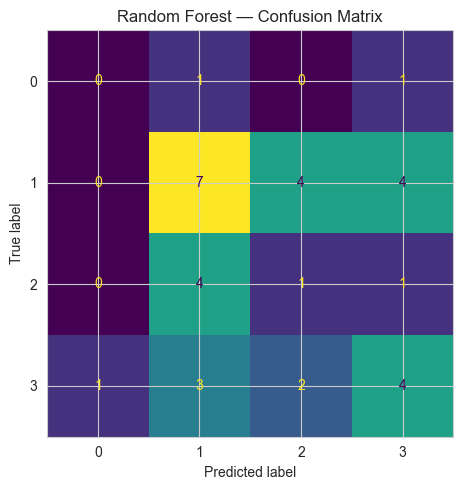

In [153]:
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax, colorbar=False)
ax.set_title('Random Forest — Confusion Matrix')
plt.tight_layout()
plt.show()

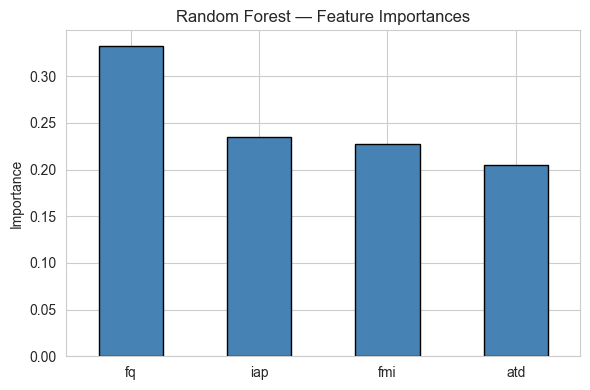

fq     0.332519
iap    0.234848
fmi    0.227362
atd    0.205270
dtype: float64


In [154]:
importances = pd.Series(rf.feature_importances_, index=FEATURES).sort_values(ascending=False)
importances.plot(kind='bar', color='steelblue', edgecolor='black', figsize=(6, 4))
plt.title('Random Forest — Feature Importances')
plt.ylabel('Importance')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
print(importances)

                         Model  Macro F1  Accuracy
Logistic Regression (Baseline)    0.1463    0.3636
      Random Forest (Ensemble)    0.2551    0.3636


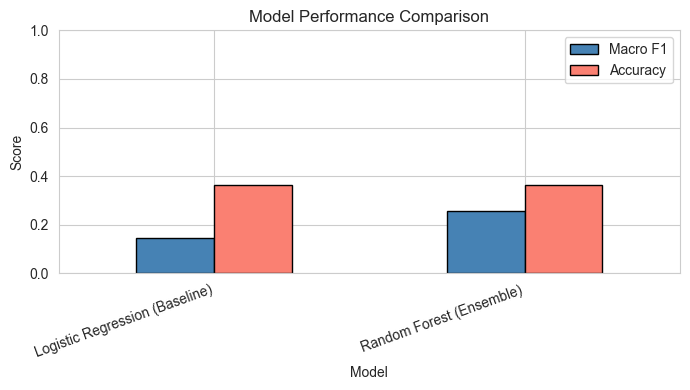

In [155]:
results = pd.DataFrame({
    'Model': ['Logistic Regression (Baseline)', 'Random Forest (Ensemble)'],
    'Macro F1': [round(base_f1, 4), round(rf_f1, 4)],
    'Accuracy': [round(base_acc, 4), round(rf_acc, 4)]
})
print(results.to_string(index=False))

results.set_index('Model')[['Macro F1', 'Accuracy']].plot(
    kind='bar', figsize=(7, 4), color=['steelblue', 'salmon'], edgecolor='black')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=20, ha='right')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

### Ensemble Model Interpretation

Compare the Random Forest macro F1 against the Logistic Regression baseline. **If the improvement is modest**, this is consistent with the clustering analysis: significant overlap between performance groups (as shown by GMM uncertainty) means that additional model complexity cannot easily learn better decision boundaries. The feature importance plot reveals which of the four selected features contribute most to the predictions, offering insight into the relative predictive power of academic behavior vs. socioeconomic factors.

---
## Section 8: (Bonus) UMAP Dimensionality Reduction

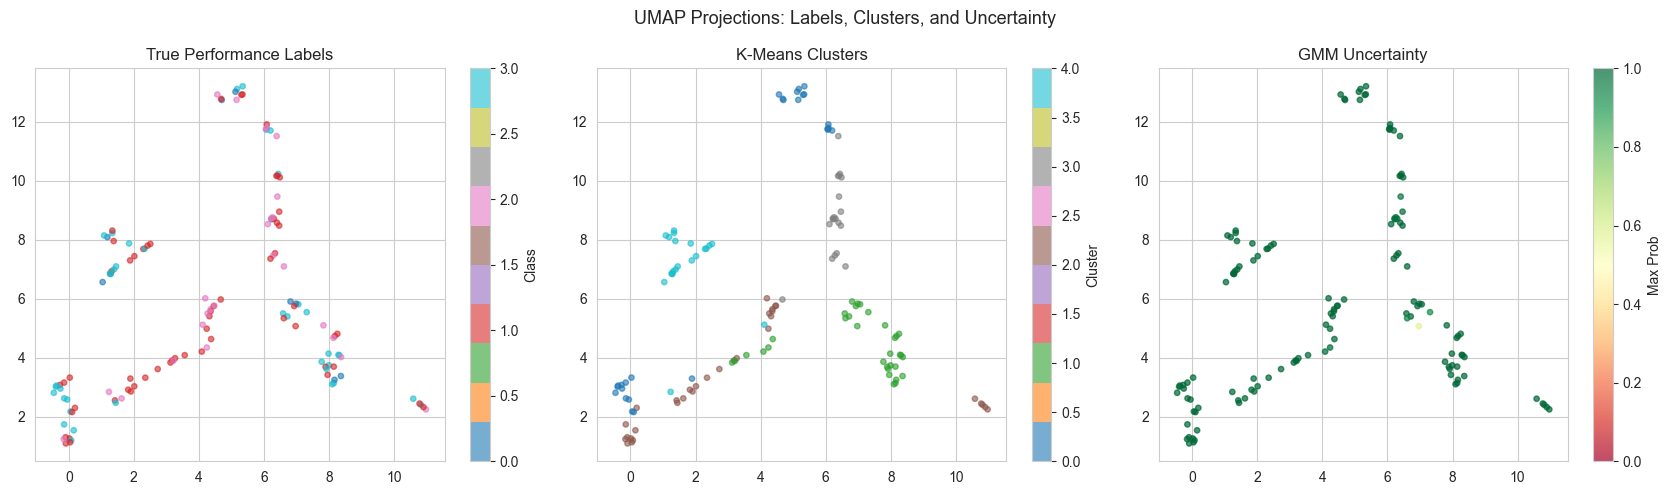

In [156]:

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2,
                        random_state=42, n_epochs=200)
X_umap = reducer.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

sc = axes[0].scatter(X_umap[:, 0], X_umap[:, 1], c=y,
                         cmap='tab10', alpha=0.6, s=15)
axes[0].set_title('True Performance Labels')
plt.colorbar(sc, ax=axes[0], label='Class')

sc2 = axes[1].scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels,
                          cmap='tab10', alpha=0.6, s=15)
axes[1].set_title('K-Means Clusters')
plt.colorbar(sc2, ax=axes[1], label='Cluster')

sc3 = axes[2].scatter(X_umap[:, 0], X_umap[:, 1], c=max_prob,
                          cmap='RdYlGn', alpha=0.7, s=15, vmin=0, vmax=1)
axes[2].set_title('GMM Uncertainty')
plt.colorbar(sc3, ax=axes[2], label='Max Prob')

plt.suptitle('UMAP Projections: Labels, Clusters, and Uncertainty', fontsize=13)
plt.tight_layout()
plt.show()


### UMAP Interpretation

UMAP preserves both local and global structure in the high-dimensional feature space. In the leftmost plot, **regions where multiple performance classes overlap** correspond directly to where the GMM assigned low certainty (red zones in the rightmost plot). The middle plot shows how well K-Means clusters align with these natural data structures. Together, these three panels contextualize the entire analysis: the limited model performance is not primarily a modeling failure but a **reflection of genuine feature-space overlap** — students with similar attendance, assessment scores, income, and parental education do achieve different performance levels, indicating that unmeasured factors (study habits, learning style, effort) also play a significant role.

---
## Section 9: Summary

| Stage | Key Finding |
|-------|------------|
| Feature selection | `atd` and `iap` likely drive most predictive signal; `fmi` and `fq` add socioeconomic context |
| Metric | Macro F1 chosen to handle class imbalance fairly across all 5 performance categories |
| K-Means | Clusters show mixed label distributions, indicating imperfect class separability |
| GMM | Significant fraction of students have ambiguous membership (low max-probability), establishing a performance ceiling |
| Ensemble | Random Forest improves over logistic baseline; magnitude of gain reflects the overlap constraints identified in clustering |
| UMAP | Visually confirms that class boundaries are soft and that uncertainty correlates with overlap regions |